### 导入autoreload扩展

In [2]:
%load_ext autoreload
%autoreload 2

### 安装依赖库

In [3]:
%more requirements.txt

matplotlib==3.7.2
numpy==1.25.2
seaborn==0.13.2
tabulate==0.9.0
tqdm==4.66.1


In [9]:
%pip install -r requirements.txt -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


### 导入必要的库和函数

In [4]:
from __init__ import *
from utils import *
from full_connect_network import FullConnectNet
from solve import Solver
from linear_layer import Linear, LinearActivation

### 下载并载入[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)数据集

In [5]:
data = download_minist()

### 封装训练函数

In [6]:
def train_with_params(
        hidden_dims, 
        activation, 
        reg, 
        update_rule,
        optim_config,
        lr_decay,
        data: Dict=data,
        weight_scale: float=0.01,
        batch_size: int=64,
        iters: int=6000,
        epochs: int=10,
        plot: bool=True,
        verbose: bool=True,
        require_loss: bool=False
    ):
    
    three_layer_model = FullConnectNet(
        hidden_dims=hidden_dims, 
        activation=activation, 
        reg=reg,
        weight_scale=weight_scale 
    )

    three_layer_net = Solver(
        model=three_layer_model, 
        data=data,
        update_rule=update_rule,
        optim_config=optim_config,
        lr_decay=lr_decay,
        batch_size=batch_size,
        print_iter=500,
        iters=iters,
        num_epochs=epochs,
        verbose=verbose,
        require_loss=require_loss
    )

    three_layer_net.train() 
    if plot:
        plot_stats_single(three_layer_net) 
    return three_layer_net

### 设置默认参数值

In [7]:
default_params = {
    'hidden_dims': [128, 64], 
    'activation': ['relu'],
    'reg': 1e-2,
    'update_rule': 'sgd',
    'optim_config': {
        'learning_rate': 1e-3
    },
    'lr_decay': 0.9
}

### 过拟合小数据集

(Time   0.01 s; Iteration     1 /  2000) loss 2.363608
[Epoch  0 / 10] train accuracy: 0.110000; val accuracy: 0.104200
[Epoch  1 / 10] train accuracy: 0.704000; val accuracy: 0.649800
[Epoch  2 / 10] train accuracy: 0.820000; val accuracy: 0.708300
(Time   1.39 s; Iteration   501 /  2000) loss 0.466822
[Epoch  3 / 10] train accuracy: 0.902000; val accuracy: 0.756000
[Epoch  4 / 10] train accuracy: 0.944000; val accuracy: 0.769200
[Epoch  5 / 10] train accuracy: 0.960000; val accuracy: 0.774100
(Time   2.53 s; Iteration  1001 /  2000) loss 0.234394
[Epoch  6 / 10] train accuracy: 0.976000; val accuracy: 0.771700
[Epoch  7 / 10] train accuracy: 0.994000; val accuracy: 0.775800
(Time   3.56 s; Iteration  1501 /  2000) loss 0.153984
[Epoch  8 / 10] train accuracy: 0.998000; val accuracy: 0.776700
[Epoch  9 / 10] train accuracy: 1.000000; val accuracy: 0.775000
[Epoch 10 / 10] train accuracy: 1.000000; val accuracy: 0.777300


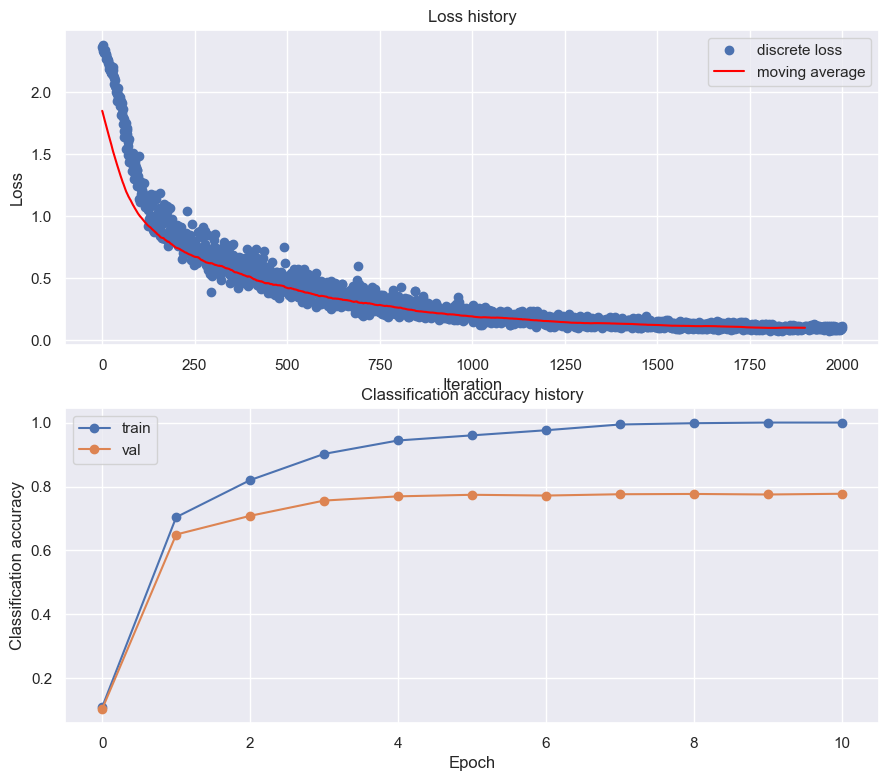

In [11]:
np.random.seed(419)
# get the first 500 samples of the testing dataset
small_data = deepcopy(data)
small_data['X_train'] = small_data['X_train'][:500]
small_data['y_train'] = small_data['y_train'][:500]

small_nn = train_with_params(
    **default_params,
    iters=2000,
    data=small_data
)

### 尝试不同组合的激活函数

Activation: (   relu,    relu) has been trained successfully!
Activation: (   relu, sigmoid) has been trained successfully!
Activation: (   relu,    tanh) has been trained successfully!
Activation: (sigmoid,    relu) has been trained successfully!
Activation: (sigmoid, sigmoid) has been trained successfully!
Activation: (sigmoid,    tanh) has been trained successfully!
Activation: (   tanh,    relu) has been trained successfully!
Activation: (   tanh, sigmoid) has been trained successfully!
Activation: (   tanh,    tanh) has been trained successfully!


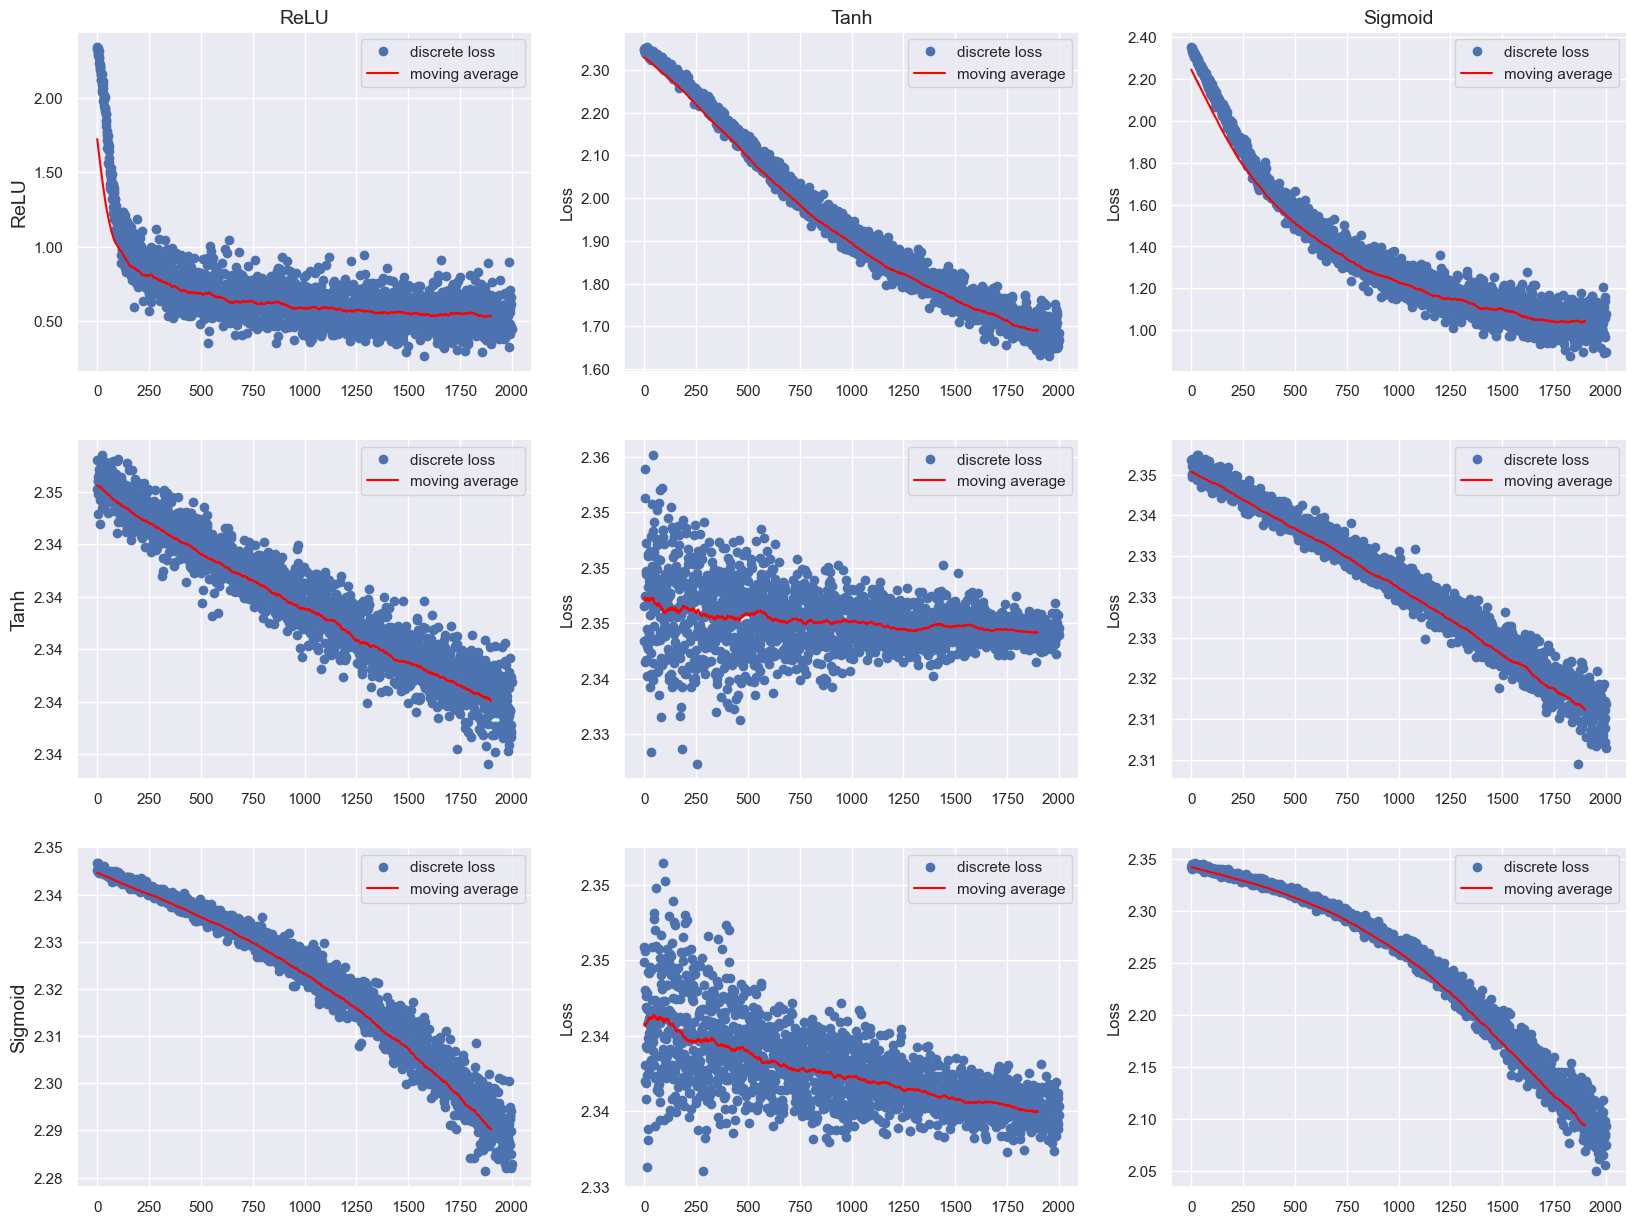

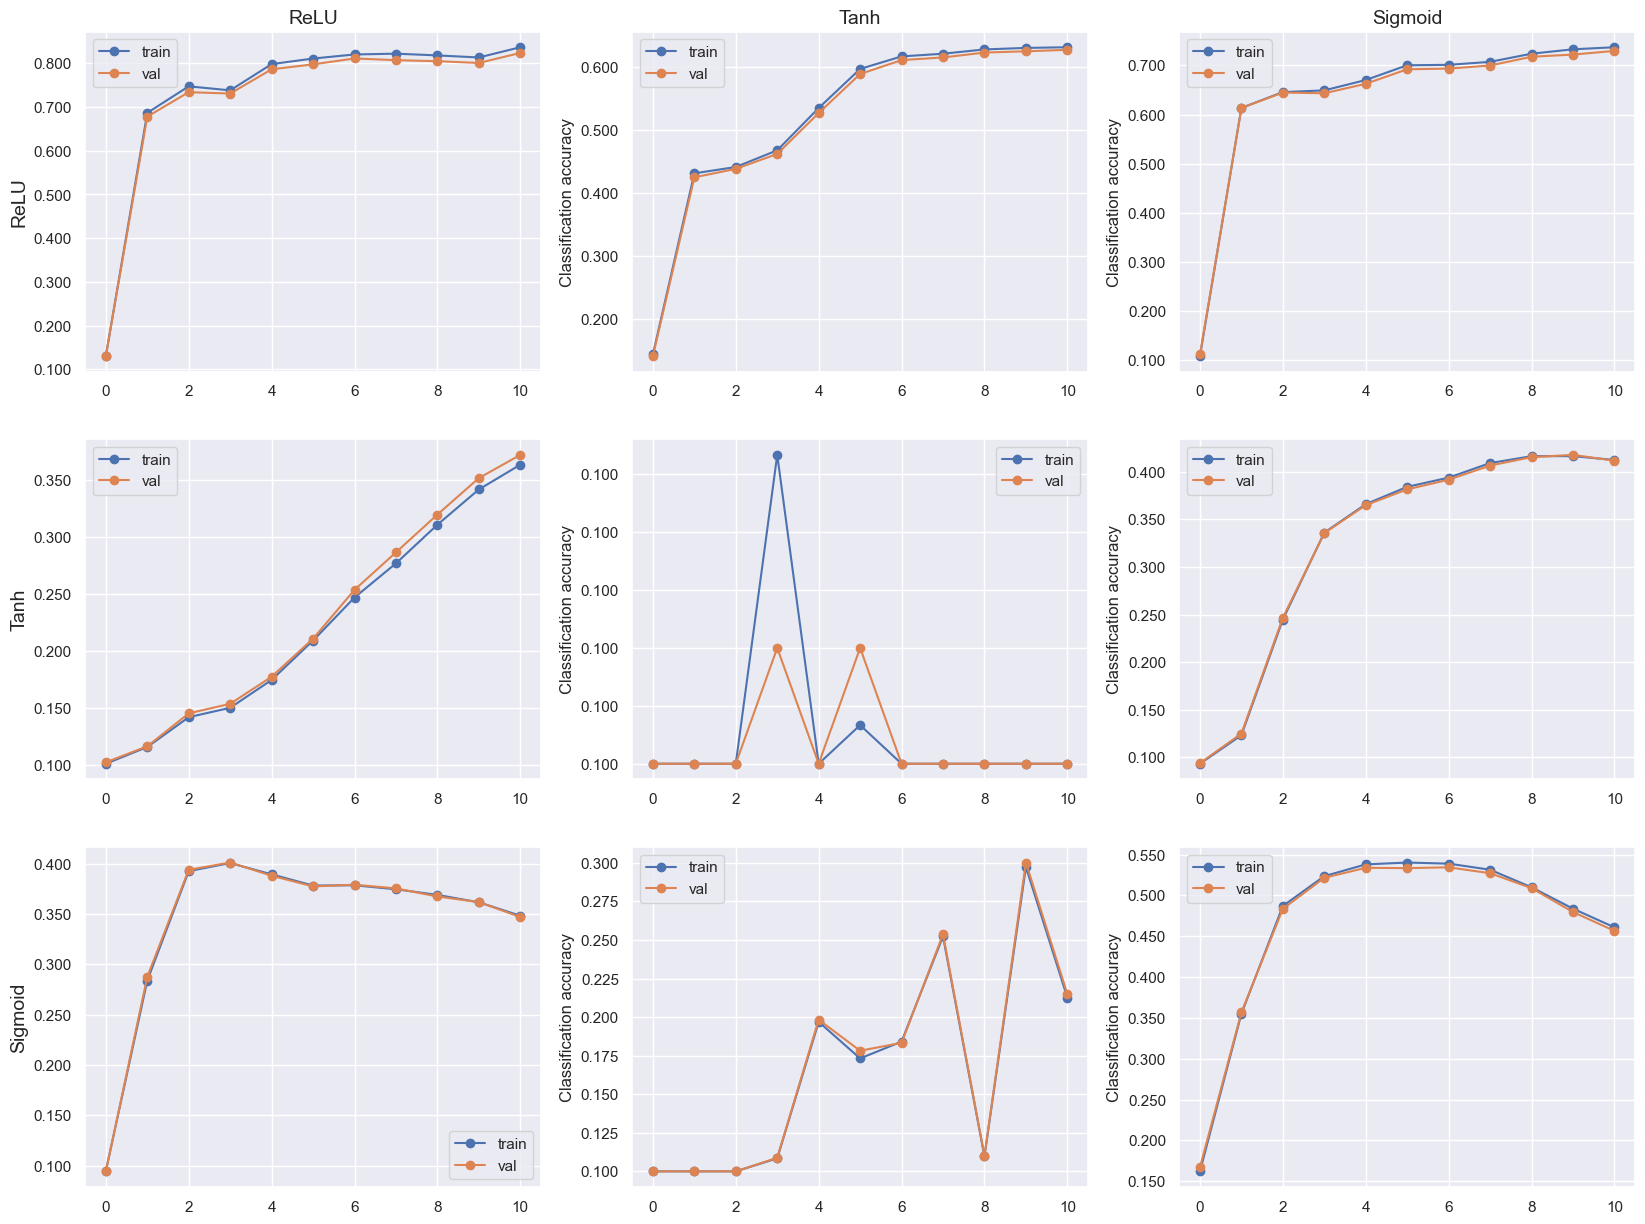

In [12]:
np.random.seed(424)

activations = ['relu', 'sigmoid', 'tanh']
avtivation_config = list(product(activations, activations))
window_size = 100

act_params = deepcopy(default_params)

#-------------------------------------------------------#

# train the model based on different activation functions
nets = []

for config in avtivation_config:
    act_params['activation'] = list(config) # modify the activation functions
    act_nn = train_with_params(
        **act_params,
        iters=2000,
        plot=False,
        verbose=False
    )
    nets.append(act_nn)
    print('Activation: ({:>7}, {:>7}) has been trained successfully!'.format(*config))

#-------------------------------------------------------#

# plot the training loss
fig_loss, axes_loss = plt.subplots(3, 3, figsize=(20, 15))
axes_loss = axes_loss.flatten()

for act_nn, ax in zip(nets, axes_loss): 
    ax.plot(act_nn.train_loss_hist, 'o', label='discrete loss')
    ax.plot([sum(act_nn.train_loss_hist[i:i+window_size])/window_size for i in range(len(act_nn.train_loss_hist)-window_size)], 'red', label='moving average')
    ax.set_ylabel("Loss")
    ax.legend()
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))


# set the x-axis label and y-axis label
activation_labels = ['ReLU', 'Tanh', 'Sigmoid']
for i, ax_row in enumerate(axes_loss.reshape(3, 3)):
    for j, ax_col in enumerate(ax_row):
        if i == 0:
            ax_col.set_title(activation_labels[j], fontsize=14)
        if j == 0:
            ax_col.set_ylabel(activation_labels[i], fontsize=14)

#-------------------------------------------------------#

# plot the accuracy curve
fig_acc, axes_acc = plt.subplots(3, 3, figsize=(20, 15))
axes_acc = axes_acc.flatten()

for act_nn, ax in zip(nets, axes_acc):
    ax.plot(act_nn.train_acc_hist, 'o-', label='train')
    ax.plot(act_nn.val_acc_hist, 'o-', label='val')
    ax.legend()
    ax.set_ylabel('Classification accuracy')
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.3f}"))
    
for i, ax_row in enumerate(axes_acc.reshape(3, 3)):
    for j, ax_col in enumerate(ax_row):
        if i == 0:
            ax_col.set_title(activation_labels[j], fontsize=14)
        if j == 0:
            ax_col.set_ylabel(activation_labels[i], fontsize=14)


### 微调正则化参数，学习率，隐藏层大小

#### 定义`cross_validation`函数

In [7]:
def cross_validation(configs: List, k: int=5):
    # train val split
    val_indices = train_val_split(data, k)
    # initialization 
    tune_params = deepcopy(default_params)
    tune_data = deepcopy(data)
    tune_acc = []
    best_acc = 0.
    best_params = deepcopy(tune_params)

    print("Total {} configurations".format(len(configs)))

    start_time = time.time()
    # iterate each configuration
    for index, config in enumerate(configs):
        tune_params['hidden_dims'], tune_params['reg'] = config[0], config[1]
        tune_params['optim_config'] = {'learning_rate': config[2]}
        accuracy = 0.

        print("*" * 5 + " " * 35, end="")
        print("Configuration {:>2} / {:>2}".format(index + 1, len(configs)), end="")
        print(" " * 34 + "*" * 5)
        # k folds
        for i in range(k):
            # split the training dataset into train&validation dataset
            val_indice = val_indices[i]
            train_indices = np.ones(len(data['X_train']), dtype=bool)
            train_indices[val_indice] = False
            train_indices, val_indice = map(list, [train_indices, val_indice])
            tune_data['X_train'] = data['X_train'][train_indices]
            tune_data['y_train'] = data['y_train'][train_indices]
            tune_data['X_val'] = data['X_train'][val_indice]
            tune_data['y_val'] = data['y_train'][val_indice]
            # train
            grid_nn = train_with_params(
                **tune_params,
                iters=2000,
                data=tune_data,
                plot=False,
                verbose=False
            )
            # print the accuracy
            accuracy += grid_nn.best_val_acc
            # compute time
            time_elapsed = time.time() - start_time
            print("[Fold {} / {}, Time: {:>2d}m {:>5.2f}s] --> validation accuracy: {:>6.4f}".format(
                i + 1, k, 
                int(time_elapsed // 60), time_elapsed % 60,
                grid_nn.best_val_acc
            ))
        accuracy /= 5
        tune_acc.append(accuracy)
        print("Configuration: hidden_dims={}, reg={:>6.4f}, learning_rate={:>6.4f}. Average val accuracy: {:>8.6f}".format(
            *config, accuracy
        ))
        print("*" * 100)
        # update best parameters
        if accuracy > best_acc:
            best_acc = accuracy
            best_params = deepcopy(tune_params)
    return tune_acc, best_params

#### 粗略查找

> 注意：该部分查找需要大约20分钟，可直接查看该代码块的输出。若运行该代码块后人为中断运行，
> 可直接跳过该代码块，运行下一个代码块给`fine_best_params`赋值，使之不影响后续代码的运行

In [8]:
np.random.seed(425)

# NOTE: you can change the hyper-parameters here
hidden_dims = [[128, 64], [128, 48], [ 64, 48]]
reg = [1e-3, 1e-2, 1e-1]
learning_rate = [1e-4, 1e-3, 1e-2]

# generate the configurations
hyper_params_configs = list(product(hidden_dims, reg, learning_rate))

tune_acc, tune_best_params = cross_validation(hyper_params_configs)


Total 27 configurations
*****                                   Configuration  1 / 27                                  *****
[Fold 1 / 5, Time:  0m 10.35s] --> validation accuracy: 0.6562
[Fold 2 / 5, Time:  0m 20.55s] --> validation accuracy: 0.6698
[Fold 3 / 5, Time:  0m 30.61s] --> validation accuracy: 0.6558
[Fold 4 / 5, Time:  0m 41.23s] --> validation accuracy: 0.6597
[Fold 5 / 5, Time:  0m 50.98s] --> validation accuracy: 0.6731
Configuration: hidden_dims=[128, 64], reg=0.0010, learning_rate=0.0001. Average val accuracy: 0.662900
****************************************************************************************************
*****                                   Configuration  2 / 27                                  *****
[Fold 1 / 5, Time:  1m  0.26s] --> validation accuracy: 0.8234
[Fold 2 / 5, Time:  1m 10.21s] --> validation accuracy: 0.8352
[Fold 3 / 5, Time:  1m 20.61s] --> validation accuracy: 0.8277
[Fold 4 / 5, Time:  1m 31.27s] --> validation accuracy: 0.8353
[Fo

In [18]:
# print(tune_best_params)
tune_best_params = {
    'hidden_dims': [128, 64], 
    'activation': ['relu'], 
    'reg': 0.001, 
    'update_rule': 'sgd', 
    'optim_config': {'learning_rate': 0.01}, 
    'lr_decay': 0.9
}

{'hidden_dims': [128, 64], 'activation': ['relu'], 'reg': 0.001, 'update_rule': 'sgd', 'optim_config': {'learning_rate': 0.01}, 'lr_decay': 0.9}


#### 使用`random_search`查找最优参数

> 注意：该部分查找需要大约20分钟，可直接查看该代码块的输出。若运行该代码块后人为中断运行，
> 可直接跳过该代码块，运行下一个代码块给`fine_tune_best_params`赋值，使之不影响后续代码的运行

Total 21 configurations
*****                                   Configuration  1 / 21                                  *****
[Fold 1 / 5, Time:  0m  8.65s] --> validation accuracy: 0.5137
[Fold 2 / 5, Time:  0m 17.42s] --> validation accuracy: 0.5755
[Fold 3 / 5, Time:  0m 26.21s] --> validation accuracy: 0.7221
[Fold 4 / 5, Time:  0m 35.28s] --> validation accuracy: 0.5839
[Fold 5 / 5, Time:  0m 43.95s] --> validation accuracy: 0.6672
Configuration: hidden_dims=[128, 64], reg=0.0083, learning_rate=0.0200. Average val accuracy: 0.612467
****************************************************************************************************
*****                                   Configuration  2 / 21                                  *****
[Fold 1 / 5, Time:  0m 52.73s] --> validation accuracy: 0.2036
[Fold 2 / 5, Time:  1m  1.23s] --> validation accuracy: 0.2828
[Fold 3 / 5, Time:  1m  9.34s] --> validation accuracy: 0.4623
[Fold 4 / 5, Time:  1m 18.38s] --> validation accuracy: 0.6790
[Fo

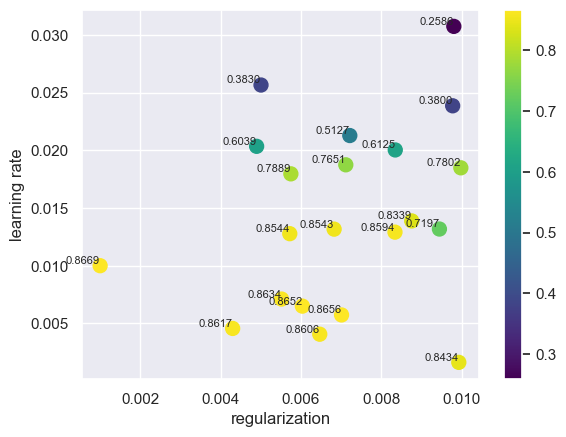

In [10]:
np.random.seed(425)

random_search_samples = 20
hidden_dims = [128, 64]
reg = np.random.uniform(10 ** -2.5, 10 ** -2, random_search_samples).tolist()
learning_rate = np.random.uniform(10 ** -3, 10 **-1.5, random_search_samples).tolist()
# also include the best parameters find above
reg.append(tune_best_params['reg'])
learning_rate.append(tune_best_params['optim_config']['learning_rate'])

fine_tune_params = [[hidden_dims, rg, lr] for rg, lr in zip(reg, learning_rate)]

fine_tune_acc, fine_tune_best_params = cross_validation(fine_tune_params)

# plot the result
plt.scatter(reg, learning_rate, c=fine_tune_acc, cmap='viridis', s=100)
plt.xlabel('regularization')
plt.ylabel('learning rate')
for i, acc in enumerate(fine_tune_acc):
    plt.text(reg[i], learning_rate[i], f'{acc:.4f}', ha='right', va='bottom', fontsize=8)
plt.colorbar()
plt.show()

In [9]:
# print(fine_tune_best_params)
fine_tune_best_params = {
      'hidden_dims': [128, 64], 
      'activation': ['relu'],
      'reg': 0.001,
      'update_rule': 'sgd',
      'optim_config': {
              'learning_rate': 0.01
          }, 
      'lr_decay': 0.9
    }

#### 不同学习率的对比

Model with learning rate 0.0001 have been trained!
Model with learning rate 0.0100 have been trained!
Model with learning rate 0.0300 have been trained!


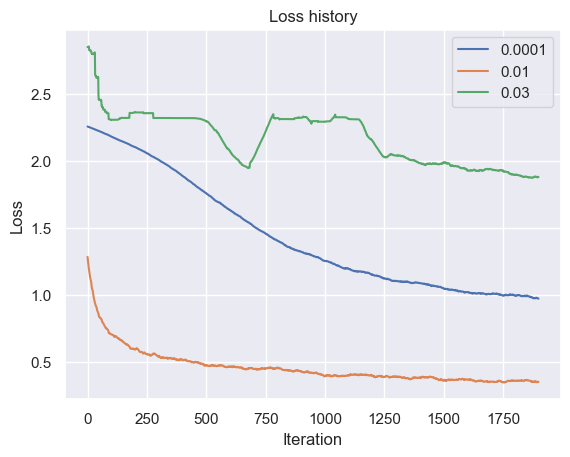

In [32]:
np.random.seed(425)

learning_rate = [1e-4, 1e-2, 0.03]

lr_params = deepcopy(fine_tune_best_params)

for lr in learning_rate:
    lr_params['optim_config'] = {
        "learning_rate": lr
    }
    lr_nn = train_with_params(
        **lr_params,
        iters=2000,
        verbose=False,
        plot=False
    )
    print("Model with learning rate {:>6.4f} have been trained!".format(lr))
    plt.plot([sum(lr_nn.train_loss_hist[i:i+window_size])/window_size for i in range(len(lr_nn.train_loss_hist)-window_size)], label=lr)
    
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### 不同的更新方式

Model with update rule sgd have been trained!
Model with update rule sgd_momentum have been trained!
Model with update rule adam have been trained!
Model with update rule rmsprop have been trained!


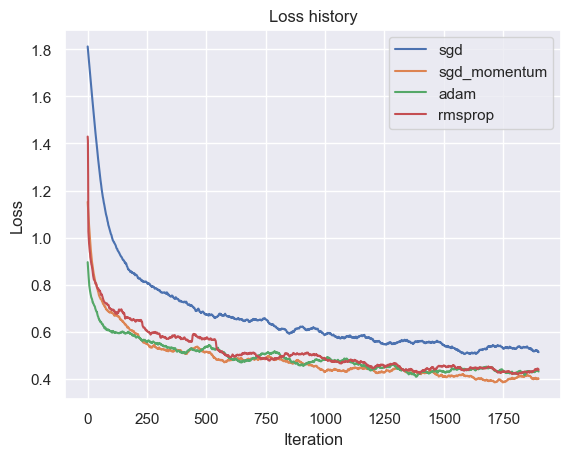

In [13]:
np.random.seed(425)

update_rules = ['sgd', 'sgd_momentum', 'adam', 'rmsprop']
window_size = 100   # used for moving average

update_params = deepcopy(fine_tune_best_params)

for update_rule in update_rules:
    update_params['update_rule'] = update_rule
    update_nn = train_with_params(
        **update_params,
        iters=2000,
        verbose=False,
        plot=False
    )
    print("Model with update rule {} have been trained!".format(update_rule))
    plt.plot([sum(update_nn.train_loss_hist[i:i+window_size])/window_size for i in range(len(update_nn.train_loss_hist)-window_size)], label=update_rule)
    
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()


### 完整训练

(Time   0.01 s; Iteration     1 / 30000) loss 2.279040
[Epoch  0 / 30] train accuracy: 0.104517; val accuracy: 0.105200
(Time   3.18 s; Iteration   501 / 30000) loss 0.299702
[Epoch  1 / 30] train accuracy: 0.816250; val accuracy: 0.800400
(Time   6.36 s; Iteration  1001 / 30000) loss 0.448486
(Time   9.14 s; Iteration  1501 / 30000) loss 0.543983
[Epoch  2 / 30] train accuracy: 0.859083; val accuracy: 0.837600
(Time  12.31 s; Iteration  2001 / 30000) loss 0.378686
(Time  15.07 s; Iteration  2501 / 30000) loss 0.370837
[Epoch  3 / 30] train accuracy: 0.863483; val accuracy: 0.842300
(Time  18.32 s; Iteration  3001 / 30000) loss 0.323727
(Time  21.09 s; Iteration  3501 / 30000) loss 0.298556
[Epoch  4 / 30] train accuracy: 0.885100; val accuracy: 0.864900
(Time  24.24 s; Iteration  4001 / 30000) loss 0.319320
(Time  27.02 s; Iteration  4501 / 30000) loss 0.091293
[Epoch  5 / 30] train accuracy: 0.896917; val accuracy: 0.873600
(Time  30.23 s; Iteration  5001 / 30000) loss 0.203717
(Time

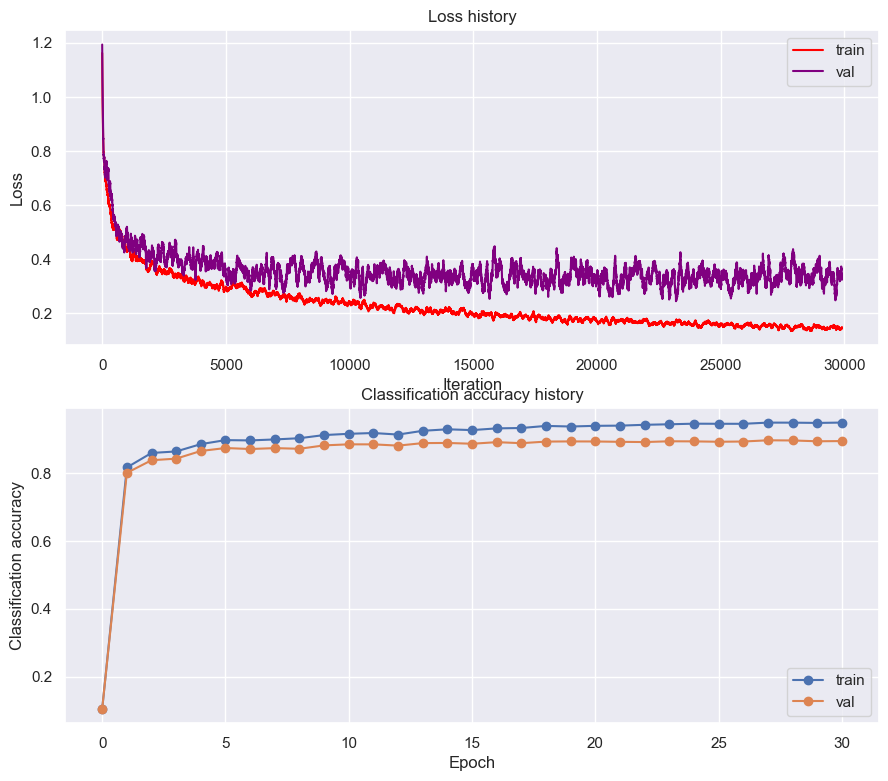

Model has been saved in model\fcnn


In [12]:
fine_tune_best_params = {
      'hidden_dims': [128, 64], 
      'activation': ['relu'],
      'reg': 0.001,
      'update_rule': 'sgd',
      'optim_config': {
              'learning_rate': 0.01
          }, 
      'lr_decay': 0.9
    }

np.random.seed(427)

nn = train_with_params(
        **fine_tune_best_params,
        iters=30000,
        epochs=30,
        require_loss=True
    )

# save the best model
model_path = 'fcnn'
nn.save(model_path)

### 载入训练好的模型

In [8]:
three_layer_trained_model = Solver(FullConnectNet(), {})

trained_model_path = 'fcnn.npz'
three_layer_trained_model.load(trained_model_path)

Successfully load model file: fcnn.npz


### 在测试集上测试

+-------------+--------------------+-------------+------------+
|             |   Accuracy(Recall) |   Precision |   F1-score |
+=============+====================+=============+============+
| T-shirt/top |             0.85   |    0.843254 |   0.846614 |
+-------------+--------------------+-------------+------------+
| Trouser     |             0.974  |    0.986829 |   0.980372 |
+-------------+--------------------+-------------+------------+
| Pullover    |             0.823  |    0.809243 |   0.816063 |
+-------------+--------------------+-------------+------------+
| Dress       |             0.898  |    0.887352 |   0.892644 |
+-------------+--------------------+-------------+------------+
| Coat        |             0.819  |    0.81982  |   0.81941  |
+-------------+--------------------+-------------+------------+
| Sandal      |             0.976  |    0.973081 |   0.974538 |
+-------------+--------------------+-------------+------------+
| Shirt       |             0.726  |    

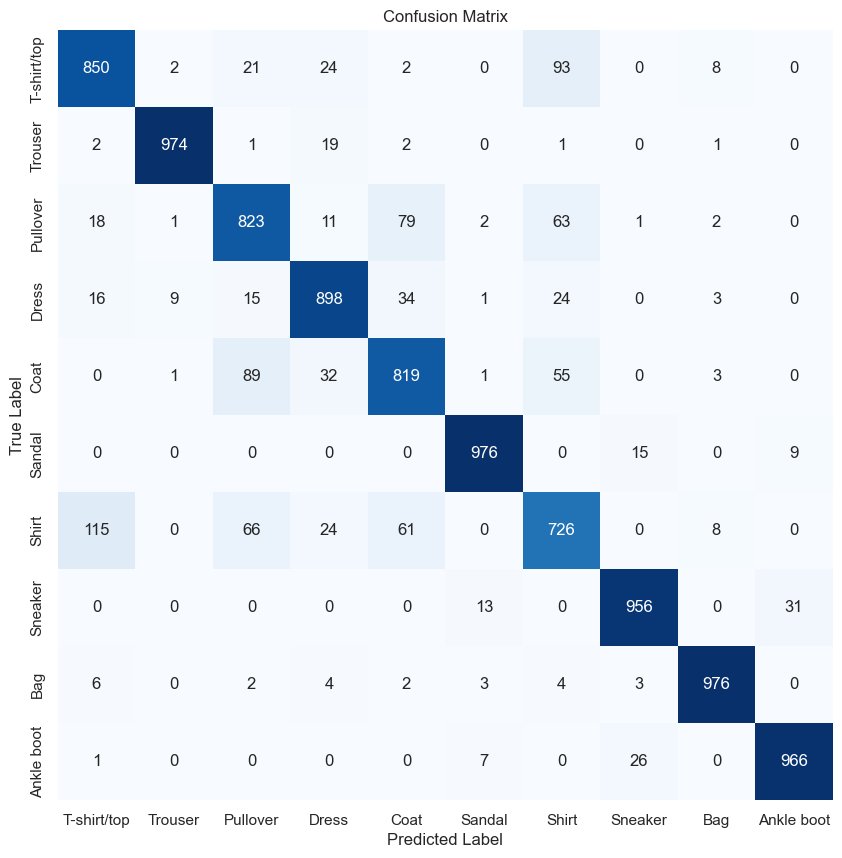

In [38]:
# labels for Fashion-MNIST dataset
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

accuracy_table, confusion_matrix = three_layer_trained_model.test_accuracy_table(
        data['X_val'], data['y_val']
    )

table_names = class_names + ['Total']
table_headers = ['Accuracy(Recall)', 'Precision', 'F1-score']

# print the table
print(tabulate(accuracy_table, headers=table_headers, showindex=table_names, tablefmt='grid'))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### 展示图片

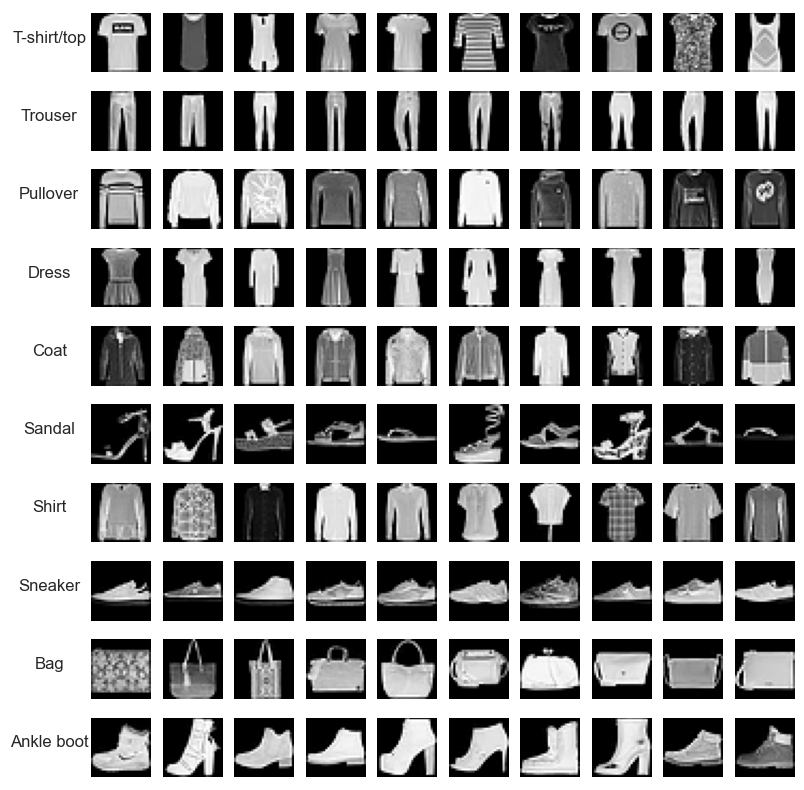

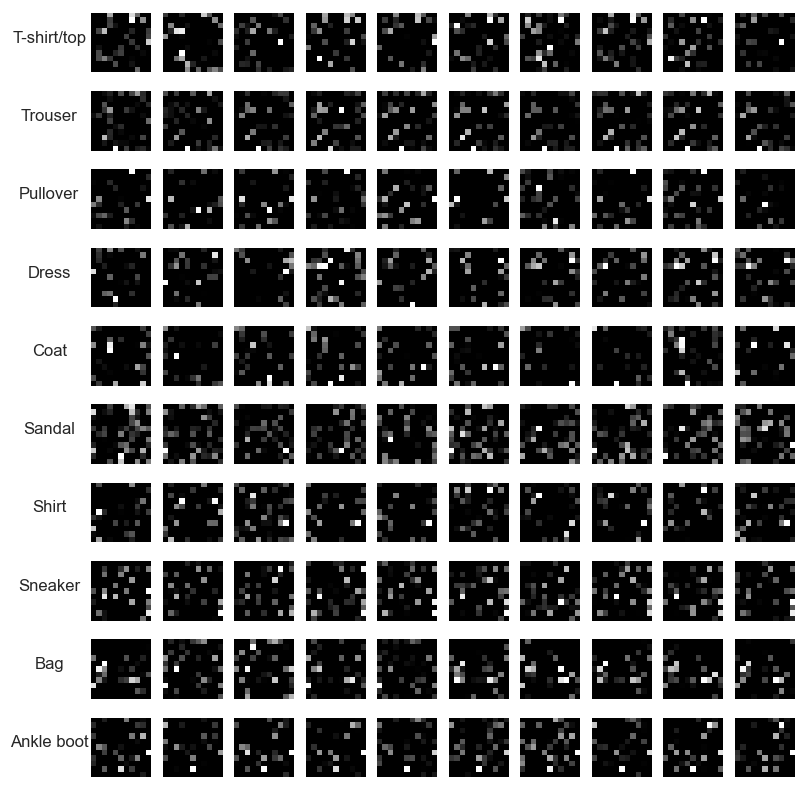

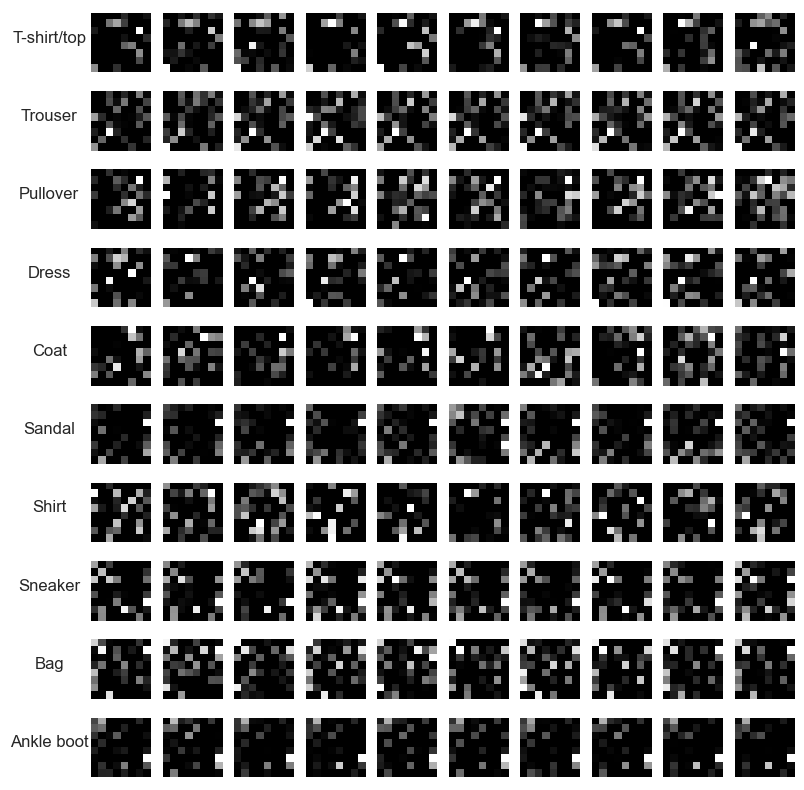

In [15]:
X_train = data["X_train"]
y_train = data["y_train"]

images_per_class = []
for label in range(len(class_names)):
    # select first 10 images for each label
    indices = np.where(y_train == label)[0][:10]  
    images_per_class.append(X_train[indices])

# get the params of the model
params = three_layer_trained_model.model.params

# grid visualize the dataset
plot_images(images_per_class, class_names, clamp=False)

# after the first layer
images_first_layer = [
        [
            LinearActivation.forward(np.expand_dims(image, axis=0), params['W1'], params['b1'], params['A1'])[0]
            for image in images
        ]
        for images in images_per_class
    ]
plot_images(images_first_layer, class_names)


# after the second layer
images_second_layer = [
        [
            LinearActivation.forward(np.expand_dims(image, axis=0), params['W2'], params['b2'], params['A2'])[0]
            for image in images
        ]
        for images in images_first_layer
    ]
plot_images(images_second_layer, class_names)

# # after the third linear layer
# images_third_layer = [
#         [
#             Linear.forward(np.expand_dims(image, axis=0), params['W3'], params['b3'])[0]
#             for image in images
#         ]
#         for images in images_second_layer
#     ]
# plot_images(images_third_layer, class_names)

### 展示权重和偏差

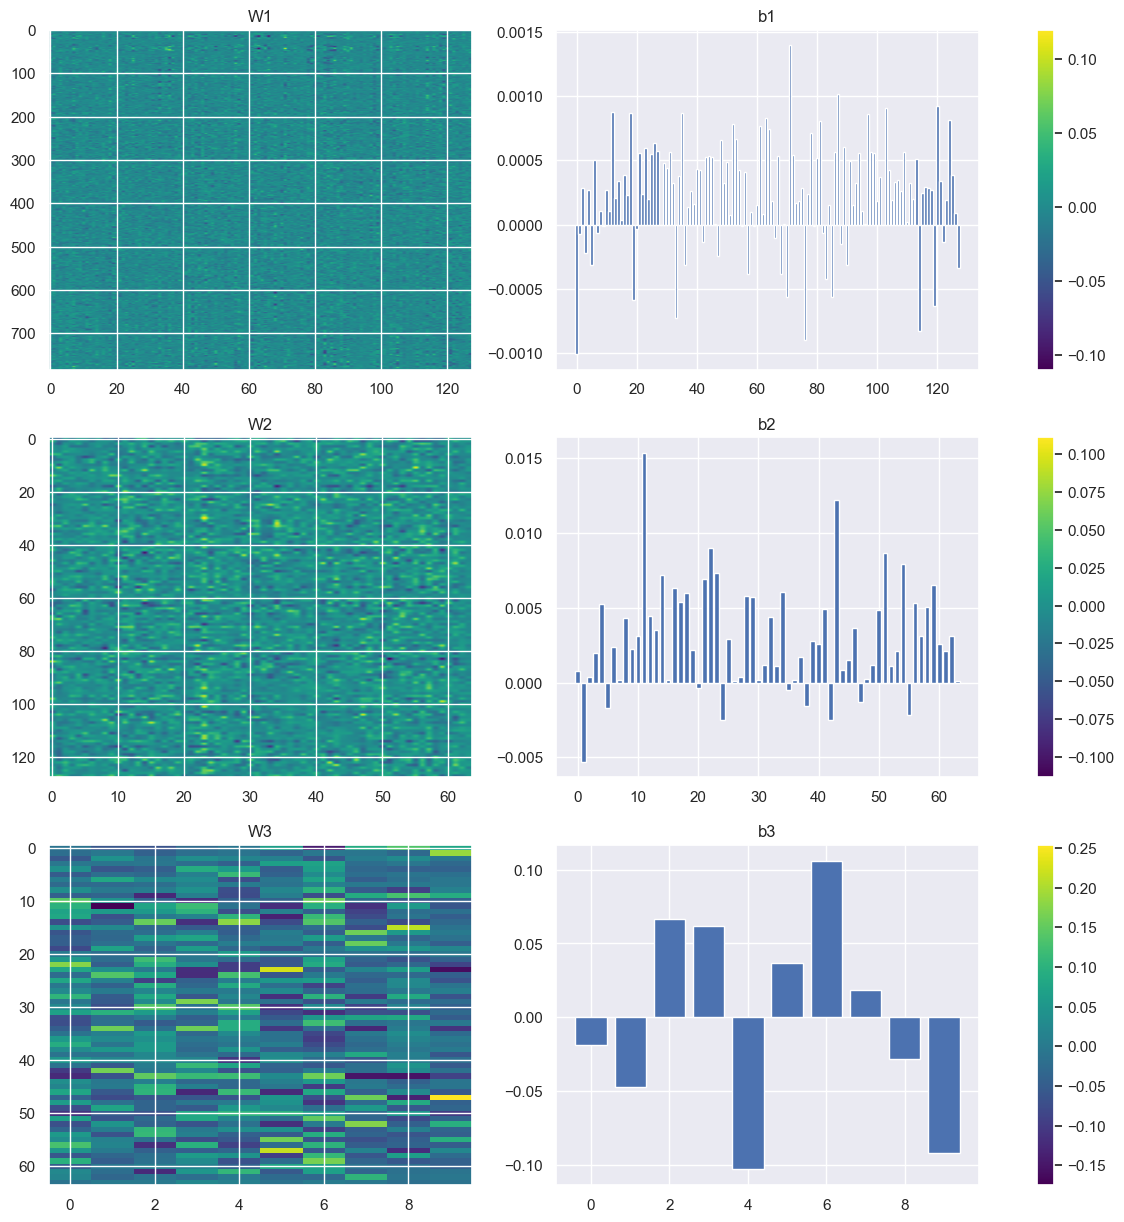

In [10]:
show_net_weights(three_layer_trained_model)